In [1]:
%pip install geopy
%pip install requests
%pip install sklearn
%pip install bs4
%pip install lxml
%pip install uszipcode
print("Installed")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Installed


In [2]:
# import any modules we might need
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from lxml import etree

from uszipcode import SearchEngine

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.7.5

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.7.5

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


In [3]:
# @hidden_cell
CLIENT_ID = 'RJD51JDJFRW1SSRLTUSSHQUTOHR4FJV20503ANRE12YQW4YC' # your Foursquare ID
CLIENT_SECRET = 'ZRQNIFPFLC3ACXEEHDYUOQZNWVYX1WTRVYF4APFU3TFM53NN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [4]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.phillymag.com/news/2013/04/24/real-estate-2013-philadelphia-neighborhoods/'
response = requests.get(url)
response.text[:100] # access html with text property

'<!DOCTYPE html>\n<html lang="en-US" prefix="og: http://ogp.me/ns#">\n\t<head>\n\t\t<meta name="viewport" c'

In [5]:
class HTMLTableParser:
    def parse_url(self, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html')
        return[(table['id'], self.parse_html_table(table))\
              for table in soup.find_all('table')]
    
    def parse_html_table(self, table):
        n_columns = 0
        n_rows = 0
        column_names = []
        
#find number of rows and columns and column titles if applcable
        for row in table.find_all('tr'):
# determine number of rows in table
            td_tags = row.find_all('td')
            if len(td_tags) > 0:
                n_rows += 1
                if n_columns == 0:
# set number of columns for our table
                    n_columns = len(td_tags)
# handle column names if we find them        
            th_tags = row.find_all('th')
            if len(th_tags) > 0 and len(column_names) == 0:
                for th in th_tags:
                    column_names.append(th.get_text())
# safeguard on column titles
        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match number of columns")
            
        columns = column_names if len(column_names) > 0 else range(0, n_columns)
        df = pd.DataFrame(columns = columns,
                         index = range(0, n_rows))
        row_marker = 0
        for row in table.find_all('tr'):
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                df.iat[row_marker, column_marker] = column.get_text()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1
# convert to float if possible 
        for col in df:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass
        return df

In [6]:
hp = HTMLTableParser()
phila = hp.parse_url(url)[0][1] # grabbing table from tuple
phila.head()

,Zip Code,Population,"Median Sales Price, 2012","Median Sales Price, 2011","Average Days on Market, 2012","Average Days on Market, 2011","Units Sold, 2012","Units Sold, 2011",Median Household Income,Percentage of Residents with a BA or Higher,Hotness
0,PENNSYLVANIA,,,,,,,,,,
1,Philadelphia,,,,,,,,,,
2,"19102 (Center City: Broad to 16th, Pine to Ca...","4,705","$361,400","$395,000",82,107,74,61,"$65,703",85%,Hot
3,19103 (Rittenhouse),"21,908","$429,000","$399,000",114,161,305,273,"$55,398",78%,Hot
4,19104 (University City/West Philadelphia),"51,808","$140,000","$122,888",95,83,128,123,"$21,801",33%,


In [7]:
# drop everything but zip code column
phila = phila[['Zip Code']]
phila.head()

,Zip Code
0,PENNSYLVANIA
1,Philadelphia
2,"19102 (Center City: Broad to 16th, Pine to Ca..."
3,19103 (Rittenhouse)
4,19104 (University City/West Philadelphia)


In [8]:
# split into two columns and rename
phila = phila['Zip Code'].str.split(' ',n=1, expand=True)
phila = phila.rename(columns={0: 'ZipCode', 1: 'Neighborhoods'})
phila.head()

,ZipCode,Neighborhoods
0,PENNSYLVANIA,None
1,Philadelphia,None
2,19102,"(Center City: Broad to 16th, Pine to Callowhill)"
3,19103,(Rittenhouse)
4,19104,(University City/West Philadelphia)


In [9]:
# drop rows that aren't zip codes by containing 19
phila = phila[(phila['ZipCode'].str.startswith('19'))]
phila

,ZipCode,Neighborhoods
2,19102,"(Center City: Broad to 16th, Pine to Callowhill)"
3,19103,(Rittenhouse)
4,19104,(University City/West Philadelphia)
5,19106,(Old City/Society Hill)
6,19107,(Center City East)
7,19111,(Fox Chase)
8,19114,(Torresdale South)
9,19115,(Bustleton)
10,19116,(Somerton)
11,19118,(Chestnut Hill)


In [10]:
# you can see 19120\r\n(Olney) didn't split correctly. manually correcting that here
phila.iat[11,0] = 19120
phila.iat[11,1] = "(Olney)"
phila

,ZipCode,Neighborhoods
2,19102,"(Center City: Broad to 16th, Pine to Callowhill)"
3,19103,(Rittenhouse)
4,19104,(University City/West Philadelphia)
5,19106,(Old City/Society Hill)
6,19107,(Center City East)
7,19111,(Fox Chase)
8,19114,(Torresdale South)
9,19115,(Bustleton)
10,19116,(Somerton)
11,19118,(Chestnut Hill)


In [11]:
# removing () from neighborhoods
phila['Neighborhoods'] = phila['Neighborhoods'].str[1:-1]
phila

,ZipCode,Neighborhoods
2,19102,"(Center City: Broad to 16th, Pine to Callowhill"
3,19103,Rittenhouse
4,19104,University City/West Philadelphia
5,19106,Old City/Society Hill
6,19107,Center City East
7,19111,Fox Chase
8,19114,Torresdale South
9,19115,Bustleton
10,19116,Somerton
11,19118,Chestnut Hill


In [12]:
# center city didn't remove first ( so manually correcting that
phila.iat[0,1] = "Center City: Broad to 16th, Pine to Callowhill"
phila

,ZipCode,Neighborhoods
2,19102,"Center City: Broad to 16th, Pine to Callowhill"
3,19103,Rittenhouse
4,19104,University City/West Philadelphia
5,19106,Old City/Society Hill
6,19107,Center City East
7,19111,Fox Chase
8,19114,Torresdale South
9,19115,Bustleton
10,19116,Somerton
11,19118,Chestnut Hill


In [13]:
# get latitude and longitude of zip codes to new list and convert to dataframe
coords_list = []

for row in phila['ZipCode']:
    search = SearchEngine(simple_zipcode=True)
    zipcode = search.by_zipcode(row)
    coords_list.append([row, zipcode.lat, zipcode.lng])
    
phila_coords = pd.DataFrame(coords_list)
phila_coords = phila_coords.rename(columns={0: 'ZipCode', 1: 'Latitude', 2: 'Longitude'})
phila_coords

,ZipCode,Latitude,Longitude
0,19102,39.953,-75.165
1,19103,39.950,-75.170
2,19104,39.970,-75.200
3,19106,39.950,-75.150
4,19107,39.950,-75.160
5,19111,40.060,-75.080
6,19114,40.070,-75.010
7,19115,40.090,-75.040
8,19116,40.120,-75.010
9,19118,40.070,-75.210


In [14]:
# merge phila and phila_coords dataframes
phila = pd.merge(phila, phila_coords, on='ZipCode')
phila

,ZipCode,Neighborhoods,Latitude,Longitude
0,19102,"Center City: Broad to 16th, Pine to Callowhill",39.953,-75.165
1,19103,Rittenhouse,39.950,-75.170
2,19104,University City/West Philadelphia,39.970,-75.200
3,19106,Old City/Society Hill,39.950,-75.150
4,19107,Center City East,39.950,-75.160
5,19111,Fox Chase,40.060,-75.080
6,19114,Torresdale South,40.070,-75.010
7,19115,Bustleton,40.090,-75.040
8,19116,Somerton,40.120,-75.010
9,19118,Chestnut Hill,40.070,-75.210


In [15]:
address = 'Philadelphia, PA'

geolocator = Nominatim(user_agent="phila_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Geographical coordinate of Philadelphia are {}, {}".format(latitude, longitude))

Geographical coordinate of Philadelphia are 39.9527237, -75.1635262


In [16]:
# create map of Philadelphia using latitude and longitude values
map_phila = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers
for lat, lng, neighborhoods, zipcode in zip(phila['Latitude'], phila['Longitude'], phila['Neighborhoods'], phila['ZipCode']):
    label = '{}, {}'.format(zipcode, neighborhoods)
    label = folium.Popup(label, parse_html=False)
    folium.CircleMarker(
    [lat, lng],
    radius=10,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_phila)

map_phila

In [17]:
# explore philadelphia neighborhoods
LIMIT=100000

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
phila_venues = getNearbyVenues(names=phila['Neighborhoods'],
                              latitudes=phila['Latitude'],
                              longitudes=phila['Longitude'])

Center City: Broad to 16th, Pine to Callowhill
Rittenhouse
University City/West Philadelphia
Old City/Society Hill
Center City East
Fox Chase
Torresdale South
Bustleton
Somerton
Chestnut Hill
Mount Airy
Olney
Strawberry Mansion/Brewerytown
Temple U. area
Northern Liberties/East Spring Garden
Juniata/Frankford
Kensington/Fishtown
Oak Lane
Manayunk
Roxborough/Andorra
East Falls
Fairmount
Wynnefield/Carroll Park
North Philadelphia West
North Philadelphia East
Richmond
Tacony
Holmesburg
Bridesburg
East Germantown
West Market
Hunting Park
Logan
Elmwood
Kingsessing
Germantown
South Philly: S. of Tasker, W. of Broad
South Philly: Pine to Tasker, W. of Broad
Bella Vista/Queen Village
South Philly: S. of Tasker, E. of Broad
Oxford Circle/Mayfair
Cedarbrook
Overbrook
Rhawnhurst
Eastwick
Torresdale North


In [19]:
# view summary of venue categories
phila_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,2,2,2,2,2,2
American Restaurant,27,27,27,27,27,27
Art Gallery,6,6,6,6,6,6
Art Museum,4,4,4,4,4,4
Arts & Crafts Store,4,4,4,4,4,4
Asian Restaurant,5,5,5,5,5,5
Athletics & Sports,1,1,1,1,1,1
Automotive Shop,1,1,1,1,1,1
Bagel Shop,2,2,2,2,2,2


In [20]:
# let's explore their locations of venue categories that may be for concerts
phila_music_venues = phila_venues[(phila_venues['Venue Category'] == 'Concert Hall') |
                                 (phila_venues['Venue Category'] == 'Event Space') |
                                 (phila_venues['Venue Category'] == 'Music Venue') |
                                 (phila_venues['Venue Category'] == 'Performing Arts Venue') |
                                 (phila_venues['Venue Category'] == 'Other Nightlife') |
                                 (phila_venues['Venue Category'] == 'Jazz Club')]
phila_music_venues = phila_music_venues.sort_values(by=['Neighborhood'])
phila_music_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
353,Center City East,39.950,-75.160,MilkBoy Philadelphia,39.950054,-75.158627,Music Venue
365,Center City East,39.950,-75.160,The Wanamaker Organ,39.951536,-75.162752,Concert Hall
10,"Center City: Broad to 16th, Pine to Callowhill",39.953,-75.165,The Wanamaker Organ,39.951536,-75.162752,Concert Hall
802,Germantown,40.030,-75.180,Temptations,40.030626,-75.180084,Other Nightlife
478,Mount Airy,40.050,-75.190,Commodore Barry Club the Irish Center,40.050098,-75.190623,Event Space
677,North Philadelphia East,39.990,-75.140,3 Elements,39.988362,-75.135439,Other Nightlife
244,Old City/Society Hill,39.950,-75.150,phillycam,39.949963,-75.152163,Performing Arts Venue
694,Richmond,39.990,-75.110,Studio 5 South,39.992791,-75.108288,Event Space
696,Richmond,39.990,-75.110,Cedar Street Studios,39.987984,-75.104992,Music Venue
162,Rittenhouse,39.950,-75.170,Curtis Institute Of Music,39.948904,-75.170627,Music Venue


In [21]:
phila_venues_grouped = phila_music_venues.groupby('Neighborhood').count()
phila_venues_grouped = phila_venues_grouped.reset_index()
phila_venues_grouped

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Center City East,2,2,2,2,2,2
1,"Center City: Broad to 16th, Pine to Callowhill",1,1,1,1,1,1
2,Germantown,1,1,1,1,1,1
3,Mount Airy,1,1,1,1,1,1
4,North Philadelphia East,1,1,1,1,1,1
5,Old City/Society Hill,1,1,1,1,1,1
6,Richmond,2,2,2,2,2,2
7,Rittenhouse,1,1,1,1,1,1
8,"South Philly: S. of Tasker, E. of Broad",3,3,3,3,3,3


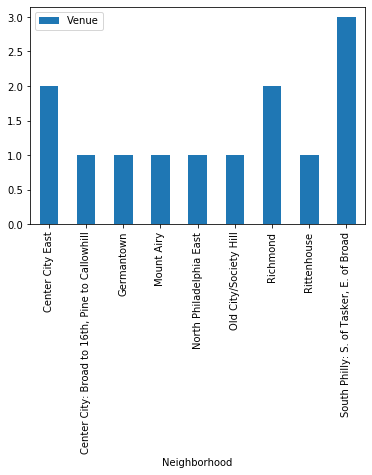

In [23]:
import matplotlib.pyplot as plt

phila_venues_plt = phila_venues_grouped[['Neighborhood', 'Venue']]
phila_venues_plt = phila_venues_plt.set_index('Neighborhood')
phila_venues_plt.plot(kind="bar")